<a href="https://colab.research.google.com/github/Cr1stal/IT8x20---Special-Topic-in-Information-Technology/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import cv2
import glob
from skimage import io, transform
from skimage import exposure
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Generate images from video

In [ ]:
print(glob.glob("/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/*.mp4"))


['/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/bike_artificial.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/bike_cloudy.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/bike_natural.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/bike_shadow.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/bike_sunny.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/car_artificial.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/car_cloudy.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/car_natural.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/car_shadow.mp4', '/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/car_sunny.mp4']


In [ ]:
list_of_files = glob.glob("/content/drive/MyDrive/IT08x20 - Assignment 2/Videos/*.mp4")
imageBasePath = "/content/drive/MyDrive/IT08x20 - Assignment 2/Images"

In [ ]:
for video_file in list_of_files:
  vidcap = cv2.VideoCapture(video_file)
  success, image = vidcap.read()
  count = 0
  imagePath = imageBasePath + '/' + Path(video_file).stem
  Path(imagePath).mkdir(parents=True, exist_ok=True)
  while success and count < 150:
    imageName = 'frame%d.PNG' % count
    cv2.imwrite(imagePath + '/' + imageName, image)
    cv2.waitKey(5)
    success, image = vidcap.read()
    print('Read frame: ', count)
    count = count + 1

# Load model

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/IT08x20 - Assignment 2/saved_model/my_model')
print("Total Params:", new_model.count_params())
new_model.summary()

Total Params: 2259265
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


# Read every image and classify it

In [ ]:
import keras.utils as image
import matplotlib.pyplot as plt
import random
import re

subdir_list = []

def read_images(path, sz=None, max_images=None):
    """Reads the images in a given folder, resizes images on the fly if size is given.

    Args:
        path: Path to a folder with subfolders representing the subjects (persons).
        sz: A tuple with the size Resizes
        max_images: The maximum number of images to read.

    Returns:
        A list [X,y]

            X: The images, which is a Python list of numpy arrays.
            y: The corresponding labels (the unique number of the subject, person) in a Python list.
    """
    c = 0
    i = 0
    strerror = ''
    errno = 0
    X = dict()
    X_original = dict()
    Y = dict()
    is_it_bike_regexp = re.compile(r"^bike")

    new_size = (sz, sz)
    image_count = 0  # counter variable
    for dirname, dirnames, filenames in os.walk(path):
        for subdirname in sorted(dirnames):
            print ('Folders are: ', subdirname)
            subdir_list.append(subdirname)
            image_count = 0
            subject_path = os.path.join(dirname, subdirname)    # subject path is leading to the car directory
            #print("subject_path: ", subject_path)
            filenames = os.listdir(subject_path)
            random.shuffle(filenames)
            for filename in filenames:
                try:
                    if (filename == ".directory"):
                        continue
                    filepath = os.path.join(subject_path, filename)
                    #print ("filepath: ", filepath)
                    im = image.load_img(os.path.join(subject_path, filename)) # filename is the name of a image
                    i = i+1
                    print('Image # ', i)
                    if (im is None):
                        print ("image " + filepath + " is none")

                    # resize to given size (if given)
                    if (sz is not None):
                        #ref: https://www.geeksforgeeks.org/image-recognition-with-mobilenet/
                        res_img = im.resize(new_size)
                        # Convert the PIL image to Tensor
                        resizedimg = image.img_to_array(res_img)
                        finalimg = np.expand_dims(resizedimg,axis=0)
                        #x = tf.cast(finalimg, tf.float32)
                        finalimg2 = tf.keras.layers.Rescaling(1./255)(finalimg)
                        #finalimg = tf.keras.applications.mobilenet_v2.preprocess_input(x)
                        finalimg2.shape

                    #X.append(np.asarray(im, dtype=np.uint8))

                    if subdirname not in X:
                      X[subdirname] = list()

                    if subdirname not in X_original:
                      X_original[subdirname] = list()

                    if subdirname not in Y:
                      Y[subdirname] = list()

                    X[subdirname].append(finalimg2)
                    X_original[subdirname].append(finalimg)
                    Y[subdirname].append(1 if is_it_bike_regexp.match(subdirname) is None else 0)

                    image_count += 1  # increment variable
                    if max_images is not None and image_count >= max_images:  # check if limit is reached
                        break
                except:
                    print ("Unexpected error:", sys.exc_info()[0])
                    raise
            #c = c+1  # c value is only chaning between car and truck
        #print('Subdir list:', subdir_list)
    return X, X_original, Y


In [ ]:
max_images = 5
# reading images from google drive an storing them in the array
X, X_original, Y = read_images('/content/drive/MyDrive/IT08x20 - Assignment 2/Images', 160, max_images) # 160 = size of images


Folders are:  bike_artificial
Image #  1
Image #  2
Image #  3
Image #  4
Image #  5
Folders are:  bike_cloudy
Image #  6
Image #  7
Image #  8
Image #  9
Image #  10
Folders are:  bike_natural
Image #  11
Image #  12
Image #  13
Image #  14
Image #  15
Folders are:  bike_shadow
Image #  16
Image #  17
Image #  18
Image #  19
Image #  20
Folders are:  bike_sunny
Image #  21
Image #  22
Image #  23
Image #  24
Image #  25
Folders are:  car_artificial
Image #  26
Image #  27
Image #  28
Image #  29
Image #  30
Folders are:  car_cloudy
Image #  31
Image #  32
Image #  33
Image #  34
Image #  35
Folders are:  car_natural
Image #  36
Image #  37
Image #  38
Image #  39
Image #  40
Folders are:  car_shadow
Image #  41
Image #  42
Image #  43
Image #  44
Image #  45
Folders are:  car_sunny
Image #  46
Image #  47
Image #  48
Image #  49
Image #  50


In [ ]:
print(X_original)

# Generate Excel file

In [ ]:
!pip install xlwt
import xlwt
from xlwt import Workbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 1.8 MB/s eta 0:00:00


In [ ]:
style_string = "align: wrap on, vert centre, horiz center"
style = xlwt.easyxf(style_string)

wb = Workbook()
sheet1 = wb.add_sheet('No processing')

sheet1.write(1, 0, 'Frame', style=style)
for i in range(5):
  sheet1.write(i+2, 0, i, style=style)

keys = list(X.keys())

for idx, key in enumerate(keys):
  sheet1.write_merge(0, 0, 2 * idx + 1, 2 * idx + 2, key, style=style)
  sheet1.write(1, 2 * idx + 1, 'TP', style=style)
  sheet1.write(1, 2 * idx + 2, 'FP', style=style)
  predicted_values = new_model.predict(tf.data.Dataset.from_tensor_slices(X[key]))
  predicted_values[predicted_values>0] = 1
  predicted_values[predicted_values<0] = 0
  for idx2, predicted_value in enumerate(predicted_values):
    actual_label = Y[key][idx2]

    # TP
    if predicted_value == actual_label:
      sheet1.write(2 + idx2, 2 * idx + 1, 1, style=style)
      sheet1.write(2 + idx2, 2 * idx + 2, 0, style=style)
    # FP
    else:
      sheet1.write(2 + idx2, 2 * idx + 1, 0, style=style)
      sheet1.write(2 + idx2, 2 * idx + 2, 1, style=style)

wb.save('xlwt example.xls')


5/5 [==============================] - 0s 31ms/step


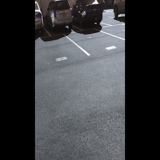

In [ ]:
cv2_imshow(np.array(X_original['car_sunny'][4][0]))

1/1 [==============================] - 2s 2s/step
[[-2.4029574]]


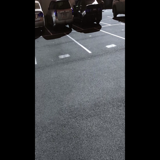

1/1 [==============================] - 0s 164ms/step
[[0.9804609]]


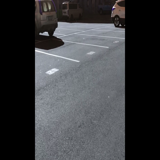

1/1 [==============================] - 0s 167ms/step
[[-1.7641925]]


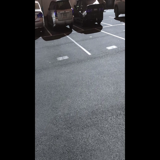

1/1 [==============================] - 0s 123ms/step
[[-0.37760544]]


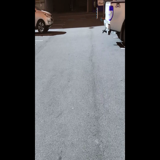

1/1 [==============================] - 0s 134ms/step
[[0.5977854]]


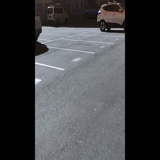

In [ ]:
for subdir in filter(lambda a : a == 'car_sunny', subdir_list):
  for j in range(5):
    print(new_model.predict(X[subdir][j]))
    cv2_imshow(np.array(X_original[subdir][j][0]))


In [ ]:
print(np.array(X_original['bike_sunny'][0][0]))
image = np.array(X_original['bike_sunny'][0][0])
cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))

[[[ 17.  12.  11.]
  [ 18.  13.  11.]
  [ 18.  15.  12.]
  ...
  [ 34.  34.  34.]
  [ 39.  40.  40.]
  [ 35.  35.  35.]]

 [[ 16.  13.  12.]
  [ 17.  14.  10.]
  [ 18.  15.  12.]
  ...
  [ 31.  31.  36.]
  [ 49.  50.  54.]
  [ 44.  46.  49.]]

 [[ 20.  15.  14.]
  [ 20.  15.  13.]
  [ 21.  16.  13.]
  ...
  [ 31.  30.  35.]
  [ 35.  35.  40.]
  [ 37.  37.  42.]]

 ...

 [[137. 135. 133.]
  [134. 134. 129.]
  [132. 132. 128.]
  ...
  [136. 130. 125.]
  [136. 130. 125.]
  [136. 130. 125.]]

 [[139. 137. 135.]
  [136. 136. 131.]
  [134. 134. 131.]
  ...
  [144. 138. 133.]
  [135. 129. 124.]
  [139. 133. 128.]]

 [[143. 141. 139.]
  [136. 136. 131.]
  [139. 139. 135.]
  ...
  [139. 133. 128.]
  [133. 127. 122.]
  [151. 145. 140.]]]


(array([[230.      , 222.85715 , 210.      , ...,   0.      ,  59.999992,
           0.      ],
        [225.      , 205.7143  , 210.      , ...,   0.      ,  12.      ,
          24.      ],
        [230.      , 222.85715 , 217.5     , ..., 348.      ,   0.      ,
           0.      ],
        ...,
        [210.      , 180.      , 180.      , ..., 212.72728 , 212.72728 ,
         212.72728 ],
        [210.      , 180.      , 180.      , ..., 212.72728 , 212.72728 ,
         212.72728 ],
        [210.      , 180.      , 180.      , ..., 212.72728 , 212.72728 ,
         212.72728 ]], dtype=float32),
 array([[0.3529412 , 0.3888889 , 0.33333334, ..., 0.        , 0.025     ,
         0.        ],
        [0.25      , 0.4117647 , 0.33333334, ..., 0.1388889 , 0.09259259,
         0.10204082],
        [0.3       , 0.35      , 0.3809524 , ..., 0.14285715, 0.125     ,
         0.11904762],
        ...,
        [0.02919708, 0.03731343, 0.03030303, ..., 0.08088236, 0.08088236,
         0.08088236

In [ ]:
# Goals
# Make another dataset with sharpen images
# Make another dataset with histogram equalized

In [ ]:
def equalize_hist_color_hsv(image):
  img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

  # equalize the histogram of the Y channel
  img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

  # convert the YUV image back to RGB format
  return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

In [ ]:
features = X_original['bike_sunny']
labels = Y['bike_sunny']
list(map(equalize_hist_color_hsv, features))

error: ignored

In [ ]:
def read_images_for_transformations(image_base_dir):
    result = []

    for dirname, dirnames, filenames in os.walk(image_base_dir):
        for subdirname in sorted(dirnames):
            print ('Folders are: ', subdirname)
            subdir_list.append(subdirname)

            subject_path = os.path.join(dirname, subdirname)

            filenames = os.listdir(subject_path)
            random.shuffle(filenames)

            for filename in filenames:
                try:
                    if (filename == ".directory"):
                        continue
                    filepath = os.path.join(subject_path, filename)
                    image = cv2.imread(filepath)
                    if (image is None):
                      print ("image " + filepath + " is none")
                      continue

                    result.append(image)
                except:
                    print ("Unexpected error:", sys.exc_info()[0])
                    raise
    return result

In [ ]:
def sharpen_image(image):
  cv::GaussianBlur(image, result, cv::Size(0, 0), 3)
  cv::AddWeighted(image, 1.5, result, -0.5, image)

In [ ]:
result_X = read_images_for_transformations('/content/drive/MyDrive/IT08x20 - Assignment 2/Images')

Folders are:  bike_artificial
Folders are:  bike_cloudy
Folders are:  bike_natural
Folders are:  bike_shadow
Folders are:  bike_sunny
Folders are:  car_artificial
Folders are:  car_cloudy
Folders are:  car_natural
Folders are:  car_shadow
Folders are:  car_sunny


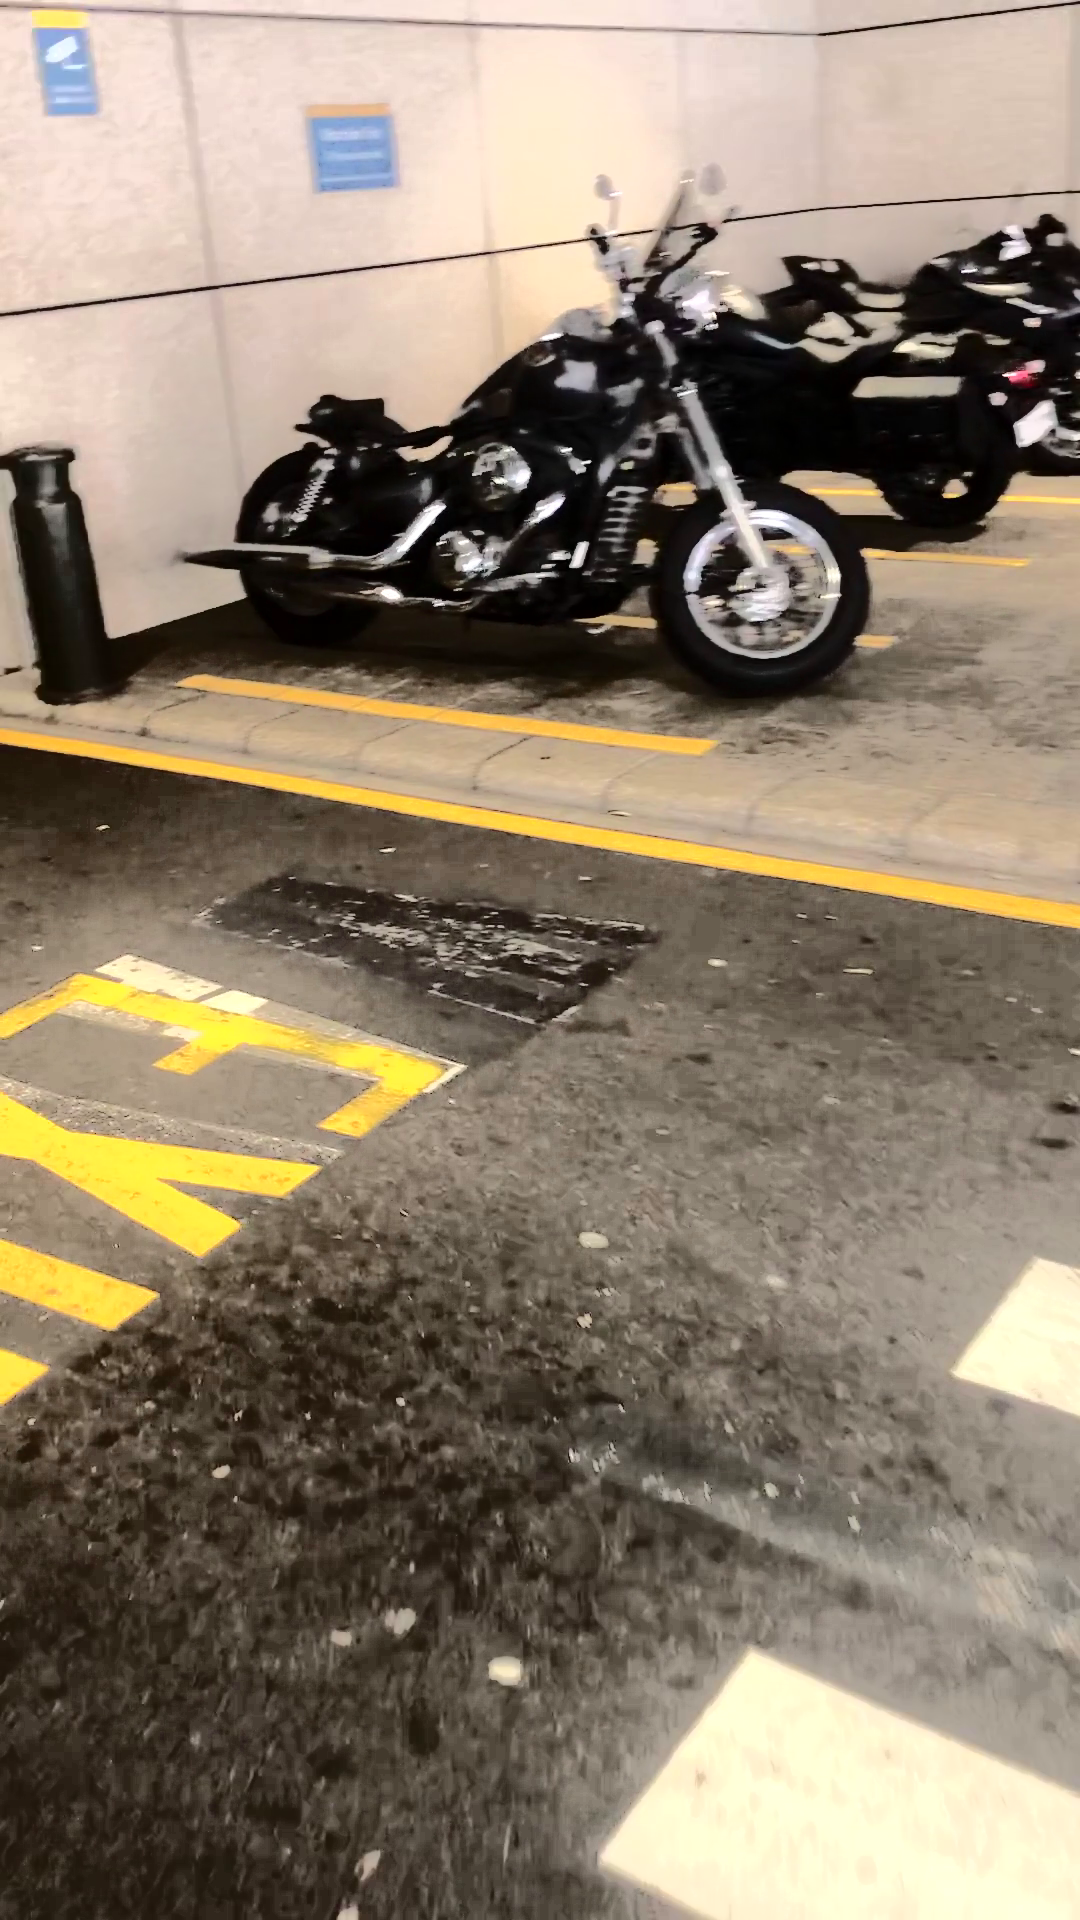

In [ ]:
cv2_imshow(equalize_hist_color_hsv(result_X[0]))